In [2]:
import pandas as pd

# Import Data
data = pd.read_csv('D:\\Kpop-lyric-datasets\\songs_sample_10~24.csv')

df = pd.DataFrame(data)
df['text'] = df['Line']
df = df[['text', 'Song Name']]

print(df.head())

           text     Song Name
0   맨 처음 그 날의 난  우리 사랑하게 됐어요.
1  아마 몰랐겠지 이런 날  우리 사랑하게 됐어요.
2  어색했었던 우리 모습이  우리 사랑하게 됐어요.
3       어제만 같은데  우리 사랑하게 됐어요.
4      기억하고 있을까  우리 사랑하게 됐어요.


In [4]:
from transformers import BertTokenizer, BertModel
import torch
import nltk
from nltk.corpus import stopwords
import pandas as pd

stop_words = set([
    '나', '너', '그', '그녀', '우리', '당신', '저', '이', '그것', '여기', '저기',
    '이', '가', '은', '는', '을', '를', '의', '에', '에서', '에게', '한테', '로', '과', '와', '도', '만', '나', '랑', '처럼', '부터', '까지', '마저',
    '그리고', '그러나', '그래서', '하지만', '역시', '또', '이제', '그냥', '정말', '너무', '아주', '다시', '이미',
    '있다', '없다', '하다', '되다', '않다', '싶다', '보다', '만나다', '살다', '가다', '오다', '들다', '보다', '듣다',
    '그대', '어떤', '그런', '모든', '아무', '많은', '많은', '같은', '이런', '저런'
])

# Bert model & tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def get_bert_embeddings(text):
    text = remove_stopwords(text)
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().detach().numpy()
    return embeddings[0]

# Data Embedding
df['embedding'] = df['text'].astype(str).apply(get_bert_embeddings)

In [6]:
# LSTM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Label Encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

# Data split
X = np.vstack(df['embedding'].values)
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM model
class LyricsClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LyricsClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_length, input_dim)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_L = LyricsClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_L.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_L.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_L(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_L.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_L(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_L.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_L(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 6.348006102602274, Train Accuracy: 14.53%, Val Loss: 5.424770111946045, Val Accuracy: 24.69%
Epoch 2/10, Train Loss: 4.843743748424869, Train Accuracy: 31.25%, Val Loss: 4.717060015820518, Val Accuracy: 33.99%
Epoch 3/10, Train Loss: 4.222211951787243, Train Accuracy: 38.79%, Val Loss: 4.381912266917618, Val Accuracy: 38.85%
Epoch 4/10, Train Loss: 3.867471443807024, Train Accuracy: 43.41%, Val Loss: 4.16064485594728, Val Accuracy: 42.39%
Epoch 5/10, Train Loss: 3.6313088491785006, Train Accuracy: 46.49%, Val Loss: 4.052684853148438, Val Accuracy: 44.26%
Epoch 6/10, Train Loss: 3.459247703257785, Train Accuracy: 48.82%, Val Loss: 3.945285718912484, Val Accuracy: 46.18%
Epoch 7/10, Train Loss: 3.3261798777960503, Train Accuracy: 50.66%, Val Loss: 3.8858657292428145, Val Accuracy: 47.06%
Epoch 8/10, Train Loss: 3.2192827279238836, Train Accuracy: 52.12%, Val Loss: 3.8193194335492393, Val Accuracy: 48.45%
Epoch 9/10, Train Loss: 3.1314287911795633, Train Accuracy: 

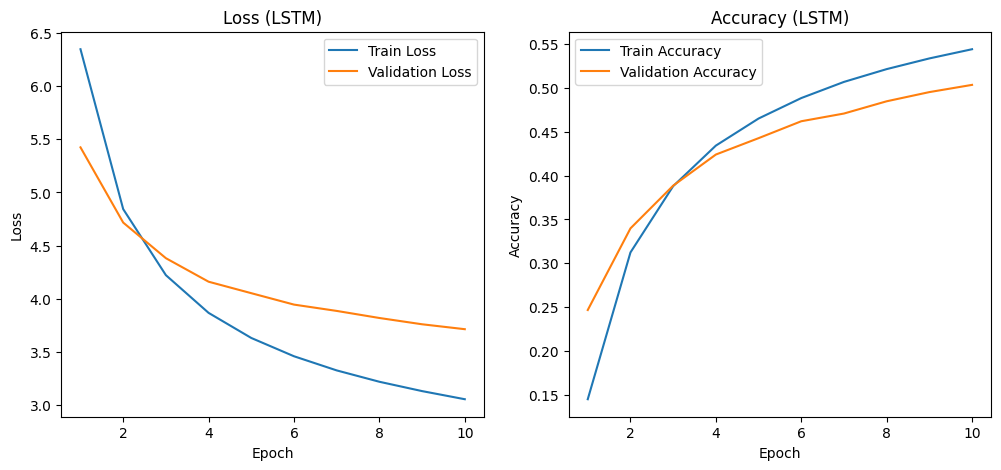

In [7]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (LSTM)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (LSTM)')
plt.legend()

plt.show()

In [8]:
# GRU

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

# Data split (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# GRU model
class LyricsGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LyricsGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_length, input_dim)
        gru_out, _ = self.gru(x)
        gru_out = gru_out[:, -1, :]
        out = self.fc(gru_out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_G = LyricsGRU(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_G.parameters(), lr=0.001)

# Data loader
train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_G.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_G(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_G.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_G(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_G.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_G(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 6.151681117783041, Train Accuracy: 16.81%, Val Loss: 5.199922351604773, Val Accuracy: 27.36%
Epoch 2/10, Train Loss: 4.640416406776707, Train Accuracy: 33.72%, Val Loss: 4.56985588395495, Val Accuracy: 36.09%
Epoch 3/10, Train Loss: 4.0604770616964485, Train Accuracy: 40.98%, Val Loss: 4.258907239824785, Val Accuracy: 40.76%
Epoch 4/10, Train Loss: 3.729588653968977, Train Accuracy: 45.20%, Val Loss: 4.061641266861025, Val Accuracy: 43.73%
Epoch 5/10, Train Loss: 3.503785463878162, Train Accuracy: 48.09%, Val Loss: 3.9324917298337514, Val Accuracy: 45.76%
Epoch 6/10, Train Loss: 3.3378730940988794, Train Accuracy: 50.28%, Val Loss: 3.836962164314193, Val Accuracy: 47.44%
Epoch 7/10, Train Loss: 3.2085835067182105, Train Accuracy: 52.02%, Val Loss: 3.749896101115905, Val Accuracy: 48.85%
Epoch 8/10, Train Loss: 3.1022480193634427, Train Accuracy: 53.48%, Val Loss: 3.6994015673051512, Val Accuracy: 49.78%
Epoch 9/10, Train Loss: 3.0143504251470716, Train Accuracy:

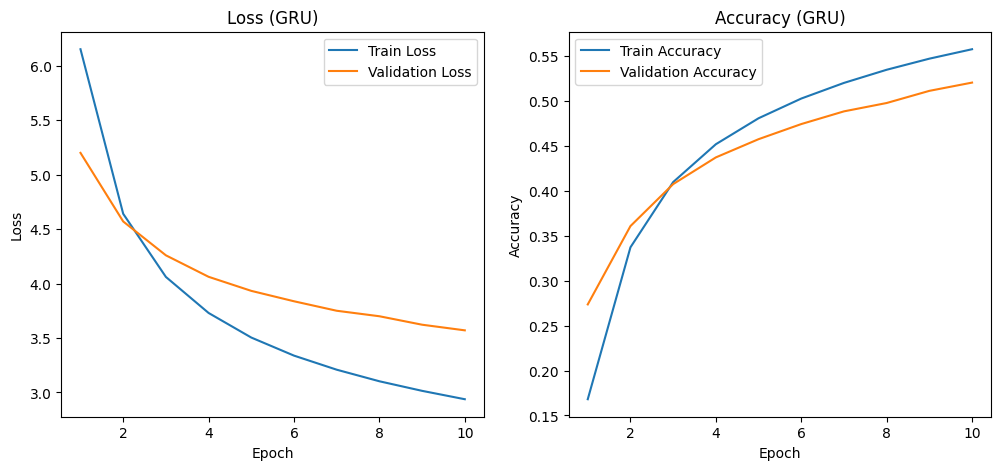

In [9]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (GRU)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (GRU)')
plt.legend()

plt.show()

In [10]:
# BiLSTM

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

# Data split (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# BiLSTM model
class LyricsBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LyricsBiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional LSTM : hidden_dim * 2

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_length, input_dim)
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_B = LyricsBiLSTM(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_B.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_B.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_B(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_B.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_B(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_B.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_B(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 5.838019300790584, Train Accuracy: 21.06%, Val Loss: 4.645171061842489, Val Accuracy: 35.14%
Epoch 2/10, Train Loss: 3.888101397226814, Train Accuracy: 44.00%, Val Loss: 3.787474925119182, Val Accuracy: 47.06%
Epoch 3/10, Train Loss: 3.092558686486704, Train Accuracy: 54.01%, Val Loss: 3.3776471294469665, Val Accuracy: 53.30%
Epoch 4/10, Train Loss: 2.65059499745629, Train Accuracy: 59.77%, Val Loss: 3.1493426845273684, Val Accuracy: 56.74%
Epoch 5/10, Train Loss: 2.3633262720716184, Train Accuracy: 63.55%, Val Loss: 2.9878176712791498, Val Accuracy: 59.39%
Epoch 6/10, Train Loss: 2.159175252744121, Train Accuracy: 66.30%, Val Loss: 2.868188464024297, Val Accuracy: 61.60%
Epoch 7/10, Train Loss: 2.004779851971183, Train Accuracy: 68.34%, Val Loss: 2.7891836029974066, Val Accuracy: 63.26%
Epoch 8/10, Train Loss: 1.8807263823204208, Train Accuracy: 70.08%, Val Loss: 2.7412893003884498, Val Accuracy: 64.18%
Epoch 9/10, Train Loss: 1.780654764397204, Train Accuracy:

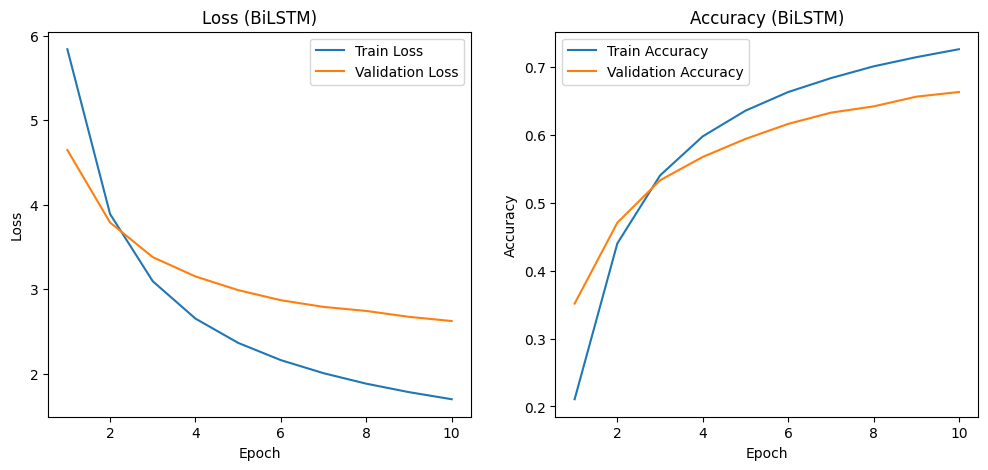

In [11]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (BiLSTM)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (BiLSTM)')
plt.legend()

plt.show()

In [12]:
# CNN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

# Data split (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# CNN model
class LyricsCNN(nn.Module):
    def __init__(self, input_dim, num_filters, filter_sizes, output_dim):
        super(LyricsCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, 1)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(3)  # (batch_size, 1, seq_length, input_dim, 1)
        conved = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        return self.fc(cat)

# Hyper-parameters
input_dim = X_train.shape[1]
num_filters = 100
filter_sizes = [2, 3, 4]
output_dim = len(label_encoder.classes_)

# Loss function, optimizer
model_C = LyricsCNN(input_dim, num_filters, filter_sizes, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_C.parameters(), lr=0.001)

# Data loader
train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_C.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_C(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_C.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_C(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_C.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_C(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 7.710772818322759, Train Accuracy: 1.90%, Val Loss: 7.445252196746333, Val Accuracy: 3.35%
Epoch 2/10, Train Loss: 7.2405218372889, Train Accuracy: 4.56%, Val Loss: 7.193784574872439, Val Accuracy: 5.29%
Epoch 3/10, Train Loss: 6.977413411263519, Train Accuracy: 6.82%, Val Loss: 7.031970447430347, Val Accuracy: 7.59%
Epoch 4/10, Train Loss: 6.7852510797985826, Train Accuracy: 8.75%, Val Loss: 6.922441016320548, Val Accuracy: 9.11%
Epoch 5/10, Train Loss: 6.632910345732549, Train Accuracy: 10.37%, Val Loss: 6.828212502858521, Val Accuracy: 10.54%
Epoch 6/10, Train Loss: 6.5046312403604665, Train Accuracy: 11.75%, Val Loss: 6.76334577904981, Val Accuracy: 11.77%
Epoch 7/10, Train Loss: 6.396297143904502, Train Accuracy: 13.03%, Val Loss: 6.694089102990849, Val Accuracy: 12.57%
Epoch 8/10, Train Loss: 6.302616556997688, Train Accuracy: 14.11%, Val Loss: 6.652117153697742, Val Accuracy: 13.57%
Epoch 9/10, Train Loss: 6.219993212860704, Train Accuracy: 15.07%, Val Lo

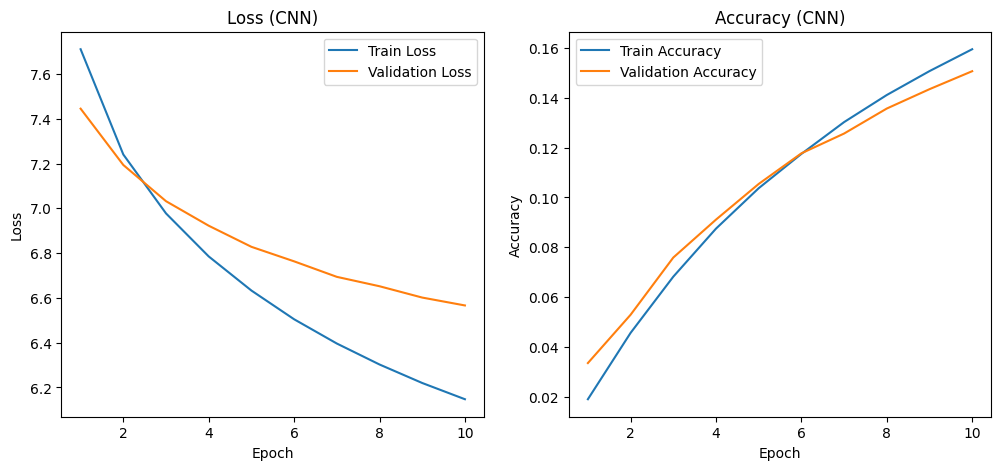

In [13]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (CNN)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (CNN)')
plt.legend()

plt.show()

In [ ]:
# Lyrics prediction
def predict_song_title_L(text):
    model_L.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_L(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.cpu().numpy())
    return song_title[0]


def predict_song_title_G(text):
    model_G.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_G(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.numpy())
    return song_title[0]


def predict_song_title_B(text):
    model_B.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_B(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.numpy())
    return song_title[0]


def predict_song_title_C(text):
    model_C.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_C(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.numpy())
    return song_title[0]

# Input new lyrics (Title : 같은 하늘 다른 시간)
new_lyrics = """
물끄러미 바라본 저 하늘을
우리 같이 보고 있었나요
아스라이 잊어버린 시간을
우린 분명 알고 있었는데

모두가 그렇듯 우린 변한 게 없는데
지나가는 순간이 많아
결국 잊혀지겠지

오늘 보는 하늘은
특별한 모습일 거야
이대로 멈췄음 해
모든 게
흘러가도 다 느껴지지 않게

같은 하늘 다른 시간
"""

L_predicted_song_title = predict_song_title_L(new_lyrics)
print(f'Predicted Song Title(LSTM): {L_predicted_song_title}')

C_predicted_song_title = predict_song_title_C(new_lyrics)
print(f'Predicted Song Title(CNN): {C_predicted_song_title}')

G_predicted_song_title = predict_song_title_G(new_lyrics)
print(f'Predicted Song Title(GRU): {G_predicted_song_title}')

B_predicted_song_title = predict_song_title_B(new_lyrics)
print(f'Predicted Song Title(BiLSTM): {B_predicted_song_title}')
